<a href="https://colab.research.google.com/github/ainesko/ML_HW/blob/main/HW6_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Перцептрон для восприятия цифр

Суммарное количество баллов: 10

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random

#Задание 1 (3 балла)

Для начала реализуем простой перцептрон.

Методы
predict(X) - возвращает предсказанные метки для элементов выборки X

fit(X, y) - инициализирует веса перцептрона, а затем обновляет их в течении iterations итераций.

Параметры конструктора
iterations - количество итераций обучения перцептрона

Поля
w - веса перцептрона размерности X.shape[1] + 1. w[0] должен соответстовать константе, w[1:] - коэффициентам компонент элемента X.

In [87]:
class Perceptron:
    def __init__(self, iterations=100):
        self.w = None
        self.iter = iterations
            
    def fit(self, X, y):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        temp = 1 / (X.shape[1] + 1) ** 0.5
        self.w = np.random.uniform(-temp, temp, size=X.shape[1])
        for _ in range(self.iter):
            for i in range(X.shape[0]):
                if np.sign(np.sum(X[i] * self.w)) != y[i]:
                    self.w += y[i] * X[i]

    def predict(self, X):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        y = np.zeros(len(X))
        for i in range(len(X)):
            y[i] = np.sign(np.sum(X[i] * self.w))
        return y

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [18]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

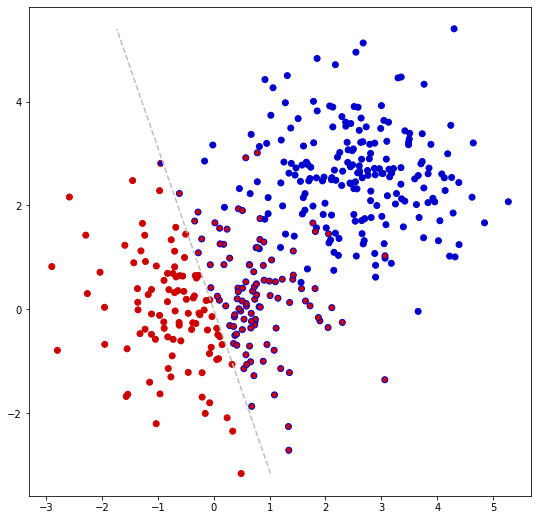

In [29]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

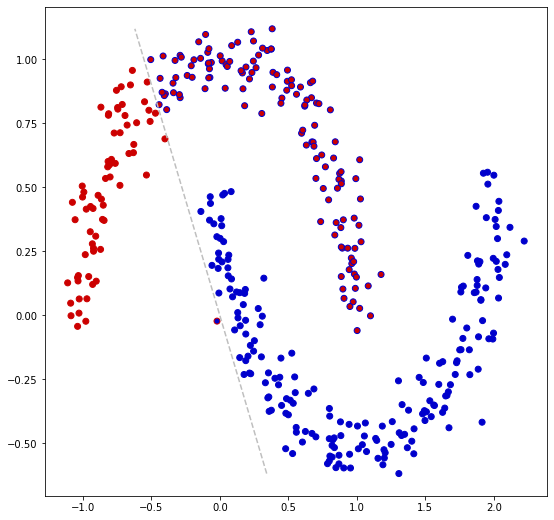

In [30]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

#Задание 2 (2 балл)

Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество X.

Реализуем перцептрон с карманом.

Методы
predict(X) - возвращает предсказанные метки для элементов выборки X

fit(X, y) - инициализирует веса перцептрона, а затем обновляет их в течении iterations итераций. В конце обучения оставляет лучшие веса.

Параметры конструктора
iterations - количество итераций обучения перцептрона

Поля
w - веса перцептрона размерности X.shape[1] + 1. w[0] должен соответстовать константе, w[1:] - коэффициентам компонент элемента X.

In [92]:
class PerceptronBest:
    def __init__(self, iterations=100, learning_rate = 1):
        self.w = None
        self.iters = iterations
        
    def h(self, X):
        y = np.sign(np.sum(X*self.w, axis=1))
        return y

    def fit(self, X, y):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        temp = 1 / (X.shape[1] + 1) ** 0.5
        self.w = np.random.uniform(-temp, temp, size=X.shape[1])
        self.best_w = self.w
        score_temp = np.mean(y == self.predict(X[:,1:]))
        for _ in range(self.iters):
            self.w = self.best_w
            for i in range(X.shape[0]):
                if np.sign(np.sum(X*self.w, axis=1))[i] != y[i]:
                    self.w += y[i] * X[i]
            if np.mean(y == self.predict(X[:,1:])) > score_temp:
                self.best_w = self.w
        self.w = self.best_w

    def predict(self, X):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        y = np.sign(np.sum(X*self.w, axis=1))
        return y

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

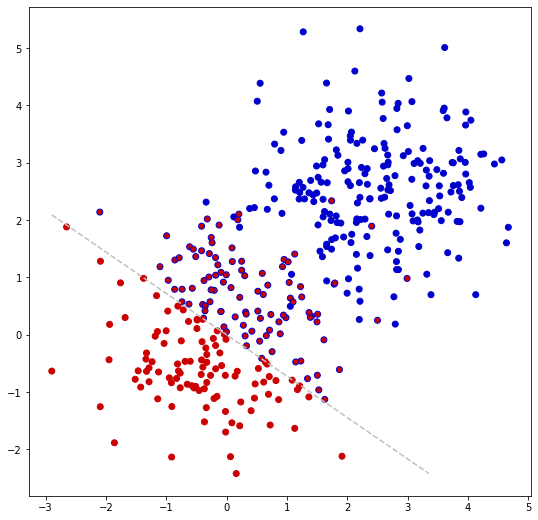

In [11]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

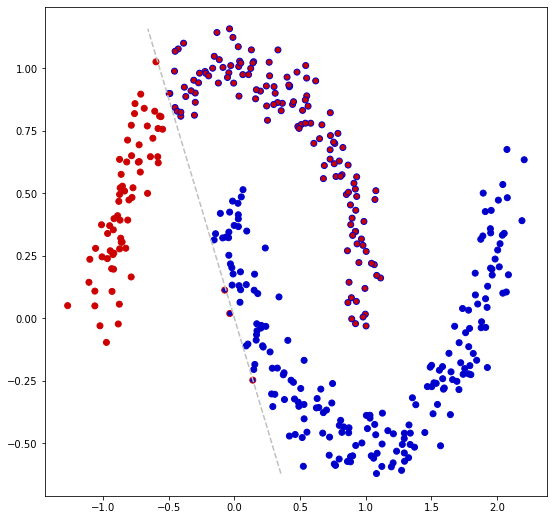

In [12]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

#Задание 3 (1 балл)

Реализуйте метод transform_images(images), который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [69]:
def transform_images(images):
    answer = []
    for img in images:
        vect = [np.sum(img), 0]
        for i in range(len(img)):
            for j in range(len(img[0])):
                if i+j < len(img)-2:
                    vect[0]+= img[i][j]
                else:
                    vect[1]+= img[i][j]
        answer.append(vect)
    return np.array(answer)

def get_digits(train_image_ids, test_image_ids):
    data = datasets.load_digits()
    images_train, labels_train = data.images[train_image_ids['ImageId'].values], data.target[train_image_ids['ImageId'].values]
    images_test, labels_test = data.images[test_image_ids['ImageId'].values], data.target[test_image_ids['ImageId'].values]
    return images_train, labels_train, images_test, labels_test

def get_digits_by_mask(images, labels, y0, y1):
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    return images, labels

def get_x_y(train_image_ids, test_image_ids, y0=1, y1=5):
    X_train, y_train, X_test, y_test = get_digits(train_image_ids, test_image_ids)

    X_train, y_train = get_digits_by_mask(X_train, y_train, y0, y1)
    X_train = transform_images(X_train)

    X_test, y_test = get_digits_by_mask(X_test, y_test, y0, y1)
    X_test = transform_images(X_test)

    return X_train, y_train, X_test, y_test

#Задание 4 (4 балла)

Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков.

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [70]:
train_ids, test_ids = pd.read_csv("x_digits_train.csv"), pd.read_csv("x_digits_test.csv")
X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids)
y_train[y_train == 1] = -1
y_train[y_train == 5] = 1
y_test[y_test == 1] = -1
y_test[y_test == 5] = 1

In [88]:
c = Perceptron(iterations=1000)
c.fit(X_train, y_train)
y_pred = c.predict(X_test)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

Accuracy: 0.9315068493150684


In [93]:
c = PerceptronBest(iterations=1000)
c.fit(X_train, y_train)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

Accuracy: 0.9315068493150684


In [ ]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
y_pred[y_pred == 1] = 5
y_pred[y_pred == -1] = 1
submission["Id"] = test_ids['Id']
submission["Expected"] = list(map(int, y_pred))
submission.to_csv('submission.csv', index=False)

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [95]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = Perceptron(iterations=2000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

ValueError: ignored

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))